In [ ]:
# See on objektipõhise pilditöötluse juturoboti Udu lähtekood
# Autorid: Kaarel Vesilind, Tarmo Pungas
# Viimati muudetud: 03.01.2022
# Töötluse alustamiseks kohanda muutujat "os_path" ning lisa programmiga samasse kausta 1) fail resnet50_coco_best_v2.1.0.h5 2) pilt, mida soovid töödelda
# Viide resnet50_coco_best_v2.1.0.h5 mudelile: https://drive.google.com/file/d/1z1vcyZrg2X7qfuaWduR6vuLx1lDGM3-L/view?usp=sharing

In [ ]:
# Vajalikud installid imageAI jaoks. Allikas: https://github.com/OlafenwaMoses/ImageAI
!pip install tensorflow==2.4.0
!pip install keras==2.4.3 numpy==1.19.3 pillow==7.0.0 scipy==1.4.1 h5py==2.10.0 matplotlib==3.3.2 opencv-python keras-resnet==0.2.0
!pip install imageai --upgrade

from imageai.Detection import ObjectDetection
# Colabi jaoks vajalikud impordid
import os
from google.colab import drive
os_path = "/content/drive/My Drive/Colab Notebooks/Tehisintellekt/Praktikum11" # TODO pane siin enda path
drive.mount('/content/drive')
os.chdir(os_path)

execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.loadModel(detection_speed="faster")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Vajalikud impordid opencv jaoks
from google.colab.patches import cv2_imshow
import cv2 as cv
import numpy as np
import re
from termcolor import colored

In [ ]:
# Kaskaadid
kaskaadid = {
    "näod": cv.CascadeClassifier("haarcascade_frontalface_default.xml"),
    "silmad": cv.CascadeClassifier("haarcascade_eye.xml")
}

In [ ]:
from IPython.core.display import Image
# Objektitöötlused
COLORS_EESTI = {'valge': (255, 255, 255), 'punane': (0, 0, 255), 'sinine': (255, 0, 0), 'kollane': (0, 255, 255),
          'cyan': (255, 255, 0), 'magenta': (255, 0, 255), 'hall': (128, 128, 128),
          'roheline': (0, 128, 0), 'must': (0, 0, 0)}
COLORS = ["white", "red", "blue", "yellow", "cyan", "magenta", "grey", "green"]
CAT_TRANSLATION = {'person': ('inimene', 'inimesed', 'inimest'), 'bicycle': ('jalgratas', 'jalgrattad', 'jalgratast'), 'car': ('auto', 'autod', 'autot'), 'motorcycle': ('mootorratas', 'mootorrattad', 'mootorratast'), 'airplane': ('lennuk', 'lennukid', 'lennukit'), 'bus': ('buss', 'bussid', 'bussi'), 'train': ('rong', 'rongid', 'rongi'), 'truck': ('veoauto', 'veoautod', 'veoautot'), 'boat': ('paat', 'paadid', 'paati'), 'traffic light': ('valgusfoor', 'valgusfoorid', 'valgusfoori'), 'fire hydrant': ('tuletõrjehüdrant', 'tuletõrjehüdrandid', 'tuletõrjehüdranti'), 'stop_sign': ('stoppmärk', 'stoppmärgid', 'stoppmärki'), 'parking meter': ('parkimisautomaat', 'parkimisautomaadid', 'parkimisautomaati'), 'bench': ('pink', 'pingid', 'pinki'), 'bird': ('lind', 'linnud', 'lindu'), 'cat': ('kass', 'kassid', 'kassi'), 'dog': ('koer', 'koerad', 'koera'), 'horse': ('hobune', 'hobused', 'hobust'), 'sheep': ('lammas', 'lambad', 'lammast'), 'cow': ('lehm', 'lehmad', 'lehma'), 'elephant': ('elevant', 'elevandid', 'elevanti'), 'bear': ('karu', 'karud', 'karu'), 'zebra': ('sebra', 'sebrad', 'sebrat'), 'giraffe': ('kaelkirjak', 'kaelkirjakud', 'kaelkirjakut'), 'backpack': ('seljakott', 'seljakotid', 'seljakotti'), 'umbrella': ('vihmavari', 'vihmavarjud', 'vihmavarju'), 'handbag': ('käekott', 'käekotid', 'käekotti'), 'tie': ('lips', 'lipsud', 'lipsu'), 'suitcase': ('kohver', 'kohvrid', 'kohvrit'), 'frisbee': ('frisbi', 'frisbid', 'frisbit'), 'skis': ('suusad', 'suusad', 'suuska'), 'snowboard': ('lumelaud', 'lumelauad', 'lumelauda'), 'sports ball': ('spordipall', 'spordipallid', 'spordipalli'), 'kite': ('tuulelohe', 'tuulelohed', 'tuulelohet'), 'baseball bat': ('pesapallikurikas', 'pesapallikurikad', 'pesapallikurikat'), 'baseball glove': ('pesapallikinnas', 'pesapallikindad', 'pesapallikinnast'), 'skateboard': ('rula', 'rulad', 'rula'), 'surfboard': ('surfilaud', 'surfilauad', 'surfilauda'), 'tennis racket': ('tennisereket', 'tennisereketid', 'tennisereketit'), 'bottle': ('pudel', 'pudelid', 'pudelit'), 'wine glass': ('pokaal', 'pokaalid', 'pokaali'), 'cup': ('tass', 'tassid', 'tassi'), 'fork': ('kahvel', 'kahvlid', 'kahvlit'), 'knife': ('nuga', 'noad', 'nuga'), 'spoon': ('lusikas', 'lusikad', 'lusikat'), 'bowl': ('kauss', 'kausid', 'kaussi'), 'banana': ('banaan', 'banaanid', 'banaani'), 'apple': ('õun', 'õunad', 'õuna'), 'sandwich': ('võileib', 'võileivad', 'võileiba'), 'orange': ('apelsin', 'apelsinid', 'apelsini'), 'broccoli': ('brokoli', 'brokolid', 'brokolit'), 'carrot': ('porgand', 'porgandid', 'porgandit'), 'hot dog': ('hotdog', 'hotdogid', 'hotdogi'), 'pizza': ('pitsa', 'pitsad', 'pitsat'), 'donot': ('sõõrik', 'sõõrikud', 'sõõrikut'), 'cake': ('kook', 'koogid', 'kooki'), 'chair': ('tool', 'toolid', 'tooli'), 'couch': ('diivan', 'diivanid', 'diivanit'), 'potted plant': ('potitaim', 'potitaimed', 'potitaime'), 'bed': ('voodi', 'voodid', 'voodit'), 'dining table': ('söögilaud', 'söögilauad', 'söögilauda'), 'toilet': ('tualett', 'tualetid', 'tualetti'), 'tv': ('teler', 'telerid', 'telerit'), 'laptop': ('sülearvuti', 'sülearvutid', 'sülearvutit'), 'mouse': ('hiir', 'hiired', 'hiirt'), 'remote': ('pult', 'puldid', 'pulti'), 'keyboard': ('klaviatuur', 'klaviatuurid', 'klaviatuuri'), 'cell phone': ('telefon', 'telefonid', 'telefoni'), 'microwave': ('mikrolaineahi', 'mikrolaineahjud', 'mikrolaineahju'), 'oven': ('ahi', 'ahjud', 'ahju'), 'toaster': ('röster', 'röstrid', 'röstrit'), 'sink': ('kraanikauss', 'kraanikausid', 'kraanikaussi'), 'refrigerator': ('külmkapp', 'külmkapid', 'külmkappi'), 'book': ('raamat', 'raamatud', 'raamatut'), 'clock': ('kell', 'kellad', 'kella'), 'vase': ('vaas', 'vaasid', 'vaasi'), 'scissors': ('käärid', 'käärid', 'paari kääre'), 'teddy bear': ('kaisukaru', 'kaisukarud', 'kaisukaru'), 'hair dryer': ('föön', 'föönid', 'fööni'), 'toothbrush': ('hambahari', 'hambaharjad', 'hambaharja')}

# Hägustab etteantud pildi
def blur(image, factor=3.0):
  # Allikas: https://www.pyimagesearch.com/2020/04/06/blur-and-anonymize-faces-with-opencv-and-python/
  
	# automatically determine the size of the blurring kernel based
	# on the spatial dimensions of the input image
  (h, w) = image.shape[:2]
  kW = int(w / factor)
  kH = int(h / factor)
	# ensure the width of the kernel is odd
  if kW % 2 == 0:
	  kW -= 1
	# ensure the height of the kernel is odd
  if kH % 2 == 0:
    kH -= 1
	# apply a Gaussian blur to the input image using our computed
	# kernel size
  return cv.GaussianBlur(image, (kW, kH), 0)

# Värvib pildi kindlat värvi
def color(image, color):
  c = COLORS_EESTI[color]
  for row in image:
    for pixel in row:
      pixel[0] = c[0]
      pixel[1] = c[1]
      pixel[2] = c[2]
  return image

def heledam(image):
  for row in image:
    for pixel in row:
      for i in range(3):
        pixel[i] = min(255, pixel[i]+100)
  return image

def tumedam(image):
  for row in image:
    for pixel in row:
      for i in range(3):
        pixel[i] = max(0, pixel[i]-100)
  return image

def kontrastsem(image):
  for row in image:
    for pixel in row:
      for i in range(3):
        pixel[i] = min(255, pixel[i]*1.5)
  return image

def vahemkontrastsem(image):
  for row in image:
    for pixel in row:
      for i in range(3):
        pixel[i] = max(0, pixel[i]*0.5)
  return image

def kollasem(image):
  for row in image:
    for pixel in row:
      pixel[0] = max(0, pixel[0]-100)
      pixel[1] = min(255, pixel[1]+100)
      pixel[2] = min(255, pixel[2]+100)
  return image

def negatiiv(image):
  for row in image:
    for pixel in row:
      pixel[i] = 255 - pixel[i]
  return image

def sinimustvalge(image):
  height = int(image.shape[0]/3)
  for row in image[0:height]:
    for pixel in row:
      pixel[0] = min(255, pixel[0]+100)

  for row in image[height:height*2]:
    for pixel in row:
      for i in range(3):
          pixel[i] = max(0, pixel[i]-150)

  for row in image[height*2:]:
    for pixel in row:
      for i in range(3):
          pixel[i] = min(255, pixel[i]+150)
  return image

def grabcut(image):
  # source: https://www.sicara.ai/blog/grabcut-for-automatic-image-segmentation-opencv-tutorial
  # Define boundary rectangle containing the foreground object
  height, width, _ = image.shape
  left_margin_proportion = 0.3
  right_margin_proportion = 0.3
  up_margin_proportion = 0.1
  down_margin_proportion = 0.1

  boundary_rectangle = (
      int(width * left_margin_proportion),
      int(height * up_margin_proportion),
      int(width * (1 - right_margin_proportion)),
      int(height * (1 - down_margin_proportion)),
  )

  gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

  binarized_image = cv.adaptiveThreshold(
      gray_image,
      maxValue=1,
      adaptiveMethod=cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      thresholdType=cv.THRESH_BINARY,
      blockSize=9,
      C=7,
  )

  # Initialize the mask with known information
  mask = np.zeros((height, width), np.uint8)
  mask[:] = cv.GC_PR_BGD
  mask[binarized_image == 0] = cv.GC_FGD

  # Arrays used by the algorithm internally
  background_model = np.zeros((1, 65), np.float64)
  foreground_model = np.zeros((1, 65), np.float64)
  number_of_iterations = 5

  cv.grabCut(
      image,
      mask,
      boundary_rectangle,
      background_model,
      foreground_model,
      number_of_iterations,
      cv.GC_INIT_WITH_MASK,
  )

  grabcut_mask = np.where((mask == cv.GC_PR_BGD) | (mask == cv.GC_BGD), 0, 1).astype(
      "uint8"
  )
  return image.copy() * grabcut_mask[:, :, np.newaxis]

def turn(img):
  rows,cols,_ = img.shape
  # cols-1 and rows-1 are the coordinate limits.
  M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),90,1)
  return cv.warpAffine(img,M,(cols,rows))

def cannyedge(img):
  edges = cv.Canny(img,100,200) 
  return cv.cvtColor(edges,cv.COLOR_GRAY2RGB)

In [ ]:
# Objektide tuvastamine
def tuvasta(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  # Tuvastame objektid ja salvestame objektide koordinaadid listi (x, y, w, h)
  tuvastatud = {}
  for kaskaad in kaskaadid.keys():
    tuvastatud[kaskaad] = kaskaadid[kaskaad].detectMultiScale(gray)
  return tuvastatud

# Opencv objektide töötlemine
def töötle(img, kaskaad, töötlus, värv):
  for (x, y, w, h) in kaskaad:
      objekt = img[y:y + h, x : x + w]
      objekt = töötle_abi(töötlus, objekt)
      img[y:y + h, x : x + h] = objekt
  return img

# ImageAI objektide töötlemine
def töötleAI(img, nimi, detections, töötlus, värv):
  for detection in detections:
    kast = detection["box_points"]
    if detection["name"] == nimi:
      objekt = img[kast[1] : kast[3], kast[0] : kast[2]]
      objekt = töötle_abi(töötlus, objekt)
      img[kast[1] : kast[3], kast[0] : kast[2]] = objekt
  return img

# Abifunktsioon kummagi töötlusviisi realiseerimiseks
def töötle_abi(töötlus, objekt):
  if töötlus == 'hägusta':
    return blur(objekt)
  elif töötlus == 'värvi':
    return color(objekt, värv)
  elif töötlus == 'eredamad':
    return heledam(objekt)
  elif töötlus == 'tumedamad':
    return tumedam(objekt)
  elif töötlus == 'kontrastsemad':
    return kontrastsem(objekt)
  elif töötlus == 'vahemkontrastsemad':
    return vahemkontrastsem(objekt)
  elif töötlus == 'kollasemad':
    return kollasem(objekt)
  elif töötlus == 'sinimustvalged':
    return sinimustvalge(objekt) 
  elif töötlus == 'esiplaan':
    return grabcut(objekt) 
  elif töötlus == 'pööra':
    return turn(objekt)
  elif töötlus == 'servasta':
    return cannyedge(objekt)  
  return objekt

# Joonistab objektidele punase ristküliku ümber
def bounding_box(img, objects):
  for (x, y, w, h) in objects:
    cv.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

Udu: Tere! Mina olen juturobot Udu ja aitan sind objektipõhise pilditöötlusega.
     Palun sisesta koos laiendiga (jpg või png) failinimi, mida soovid töödelda.
Kasutaja: test2.jpg


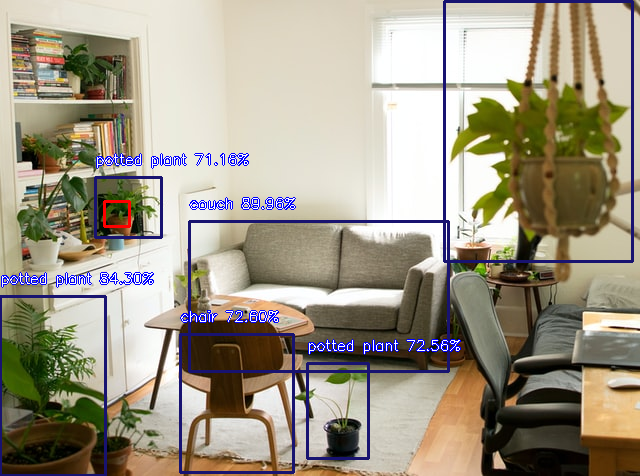

Udu: Leidsin pildi. Pildil on: 1 silm, 1 diivan, 4 potitaime, 1 tool
Udu: Vali, mis objektidele millist töötlust teha soovid. Proovi näiteks "hägusta näod" või "värvi silmad" (alati mitmuses). Kõigi võimaluste nägemiseks sisesta "abi".
Kasutaja: servasta diivan
Udu: Ma ei saanud aru. Proovi uuesti.
Kasutaja: servasta diivanid


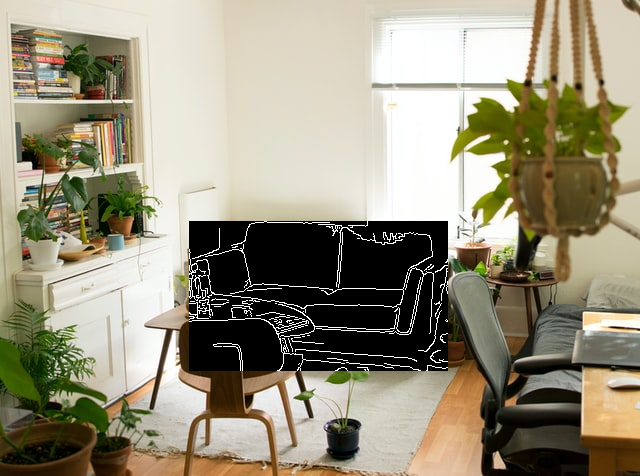

Udu: Siin on töödeldud pilt. Kui soovid midagi veel töödelda, siis kirjuta uus töötlus samal viisil.
     Kui soovid töödeldud pilti salvestada, kirjuta "salvesta". Kui soovid lahkuda, kirjuta "lahkun"
Kasutaja: lahkun
Peatse kohtumiseni!


In [ ]:
import time
minimum_percentage_probability = 70 # Saab reguleerida kui tundlik ImageAI on
COMMANDS = ["hägusta", "värvi", "eredamad", "tumedamad", "kontrastsemad", "vahemkontrastsemad", "kollasemad", "sinimustvalged", "esiplaan", "pööra", "servasta" ]  # kõik töötluse viisid, mis on saadaval
OBJECTS = []  # kõik objektid, mida on võimalik tuvastada

# Käsurea kasutajaliides
# 1) Küsib kasutajalt pildifaili nime
# 2) Kuvab kasutajale, mis objekte ta tuvastas
# 3) Küsib kasutajalt, mis objektidele mis töötlust tahab
# 4) Näitab kasutajale töödeldud pilti, kui kasutaja soovib töötlemist jätkata, siis tal on see võimalus, kui ei siis lahkudes programm läheb kinni.
print("Udu: Tere! Mina olen juturobot Udu ja aitan sind objektipõhise pilditöötlusega.\n     Palun sisesta koos laiendiga (jpg või png) failinimi, mida soovid töödelda.")
töötlemine = False
värvimine = False
värv = ''
while True:
    human = input("Kasutaja: ")
    human = human.lower()

    # Lõpetame töö
    if human == "lahkun":
        print("Peatse kohtumiseni!")
        break

    # Salvestame pildi
    elif human == "salvesta":
      töötlemine = False
      try:
        name = filename.split(".")[0]
        extension = filename.split(".")[1]
        cv.imwrite(name + "_töödeldud." + extension, img)
        print("Udu: Salvestamine õnnestus! :)")
        continue
      except:
        print("Udu: Salvestamine ebaõnnestus :(")
        continue

    # Abi
    elif human == "abi":
      print("Udu: Objektid, mis tuvastati pildilt:", ", ".join(OBJECTS))
      print("     Saadaval töötluse viisid:", ", ".join(COMMANDS))
      continue

    # Arvuti vastus lausele
    response = ""

    if töötlemine:
      if värvimine:
        värv = human
        värvimine = False
      else:   
        human = human.strip().split()
        if len(human) != 2:
          print("Udu: Ma ei saanud aru. Proovi uuesti.")
          continue
        töötlus = human[0]
        objekt = human[1]
        if objekt not in OBJECTS or töötlus not in COMMANDS:
          print("Udu: Ma ei saanud aru. Proovi uuesti.")
          continue
        if töötlus == 'värvi':
          print("Udu: Valikus on sellised värvid:")
          print("     must")
          for i in range(len(COLORS)):
            print(colored("     " + list(COLORS_EESTI.keys())[i], COLORS[i]))
          värvimine = True
          print('Udu: Mis värvi soovid ' + objekt + ' värvida?')
          continue
      
      if objekt in kaskaadid.keys():  # opencv töötlus
        img = töötle(img, tuvastused[objekt], töötlus, värv)
      else:  # ImageAI töötlus
        # Tõlgi objekt tagasi inglise keelde
        for key, val in CAT_TRANSLATION.items():
          if objekt in val:
            objekt = key
            break
        img = töötleAI(img, objekt, detections, töötlus, värv)
      cv2_imshow(img)
      time.sleep(0.5)  # Selleks, et tekstikast pildi taha ei kaoks
      response = 'Siin on töödeldud pilt. Kui soovid midagi veel töödelda, siis kirjuta uus töötlus samal viisil.\n     Kui soovid töödeldud pilti salvestada, kirjuta "salvesta". Kui soovid lahkuda, kirjuta "lahkun"'
    
    # Sisestati pildifaili nimi
    elif re.search(r"(.*)\.(jpg|png)", human):
        filename = human
        try:
          response += "Leidsin pildi. Pildil on: "
          img = cv.imread(human)
          tuvastused = tuvasta(img)  # opencv tuvastused
          img_detected, detections = detector.detectObjectsFromImage(output_type="array", input_image=human, minimum_percentage_probability=minimum_percentage_probability)  # ImageAI tuvastused
          for objekt in tuvastused.keys():
            bounding_box(img_detected, tuvastused[objekt])  # Teeme kastid ümber leitud objektide
          cv2_imshow(img_detected)  # Näitame pilti
          time.sleep(0.5)  # Selleks, et tekstikast pildi taha ei kaoks


          for kaskaad in tuvastused.keys():
            if kaskaad == "näod":
              kääne = "nägu"
            else:
              kääne = "silma"
            arv = len(tuvastused[kaskaad])
            if arv > 0:
              if arv == 1 and kääne == "silma":
                response += str(arv) + ' ' + kääne[:-1] + ', '
              else:
                response += str(arv) + ' ' + kääne + ', '
              OBJECTS.append(kaskaad)

          # Leiame kõik ImageAI unikaalsed tuvastused
          names = {}
          for detection in detections:
            name = detection["name"]
            if name not in names.keys():
              names[name] = 1
              OBJECTS.append(CAT_TRANSLATION[name][1])
            else:
              names[name] += 1

          for name, amount in names.items():
            if amount == 1:
              response += str(amount) + ' ' + CAT_TRANSLATION[name][0] + ', '
            else:
              response += str(amount) + ' ' + CAT_TRANSLATION[name][2] + ', '
          response = response[:-2]

          response += '\nUdu: Vali, mis objektidele millist töötlust teha soovid. Proovi näiteks "hägusta näod" või "värvi silmad" (alati mitmuses). Kõigi võimaluste nägemiseks sisesta "abi".' 
          töötlemine = True
        except Exception as err:
          # print(err)
          response = "Ei leidnud pilti või tekkis muu viga. Sisesta palun uuesti 🙏"
    else:
        response = "Ma ei saanud aru."
    print("Udu:", response)